# Wykorzystanie VAE w celu ekstrakcji cech do poszukiwania podobnych twarzy ze zbioru CelebA

<img src="https://pbs.twimg.com/media/Cxf17XAUAAAnGX9.jpg",width=800>
<img src="http://mmlab.ie.cuhk.edu.hk/projects/celeba/intro.png",width=800>

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Zaimportowanie bibliotek

In [2]:
#operacje związane ze ścieżkami
import os
from glob import glob

#operacje na macierzach
import numpy as np

#operacje na obrazach
from PIL import Image

#miła dla oka wizualizacja postępu i nie tylko
from tqdm import tqdm

#tworzenie wykresów i wizualizacja danych
import matplotlib.pyplot as plt
import seaborn as sns

#funkcja ułatwiająca podział zbioru danych na treningowy i testowy
from sklearn.model_selection import train_test_split

#importy z biblioteki keras, umożlkiwiające krótszy zapis implementacji
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
np.random.seed(1118) #ziarno do generacji liczb pseudolosowych - wybierz swoje, ale może wpłynąć na wyniki

## Stałe wykorzystywane w następnych krokach

In [4]:
dataset_dir = '../img_align_celeba'
model_dir = '../models'

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

## Wczytanie danych

In [6]:
img_paths = glob(dataset_dir+'/*.jpg')

In [7]:
print('Mamy',str(len(img_paths)),'obrazów.')

Mamy 202599 obrazów.


In [8]:
print(img_paths[:10])

['../img_align_celeba\\000001.jpg', '../img_align_celeba\\000002.jpg', '../img_align_celeba\\000003.jpg', '../img_align_celeba\\000004.jpg', '../img_align_celeba\\000005.jpg', '../img_align_celeba\\000006.jpg', '../img_align_celeba\\000007.jpg', '../img_align_celeba\\000008.jpg', '../img_align_celeba\\000009.jpg', '../img_align_celeba\\000010.jpg']


### Wykorzystamy losowo wybrane 10 000 obrazów

In [9]:
rnd_choice = np.random.choice(len(img_paths),10000)

Następnie poddamy je następującym zabiegom:
* Odcięcie krawędzi - umożliwiające relatywnie bezstratne wykonanie operacji 2-krotnego zmniejszenia wielkości (downsampling) podczas dalszych kroków, jak i przejścia przez kolejne warstwy sieci neuronowej (218x178 -> 192x160),
* 2-krotne próbkowanie w dół - w celu przyśpieszenia treningu i umożliwienia go nawet na słabszych maszynach.

Powyższe operacje wykonamy przy pomocy metod obiektu PIL.Image, co znacząco przyśpieszy proces i pozwili na zaoszczędzenie pamięci operacyjnej.

Dodatkowo zeskalujemy obrazy do wartości 0-1 w każdym z 3 kanałów: R, G, B.


In [10]:
images = np.array(
    [np.array(Image.open(img_paths[x]).
              crop(box=(9,13,169,205)).
              resize((80,96)))
     for x in tqdm(rnd_choice.tolist())]).astype(np.float32)

for i in range(3):
    images[:,:,:,i] = (images[:,:,:,i] - np.min(images[:,:,:,i]))/(np.max(images[:,:,:,i])-np.min(images[:,:,:,i]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1372.60it/s]


In [11]:
print('Wymiary macierzy obrazów to:',images.shape)

Wymiary macierzy obrazów to: (10000, 96, 80, 3)


## Wizualizacja danych

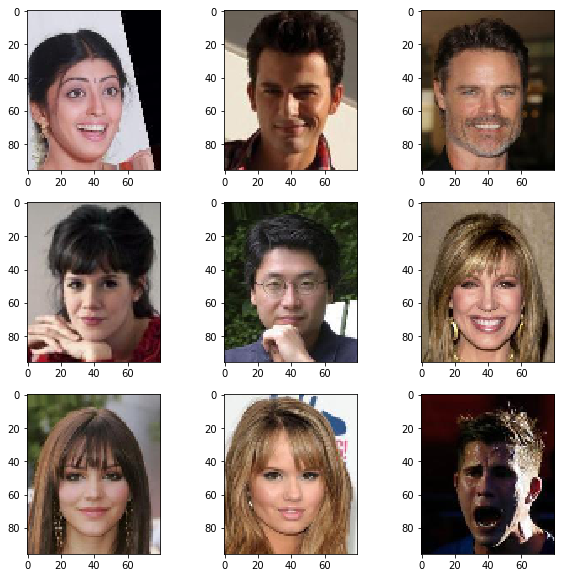

In [12]:
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(np.squeeze(images[i]))

## Budowa modelu wariacyjnego autoenkodera
Baza: https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py

### Zdefiniowanie parametrów określających architekturę VAE

In [13]:
kernel_size = 3 #zwyczajowa wielkość fitra konwolucyjnego
filters = 16 #liczba filtrów dla pierwszej warstwy konwolucyjnej, rośnie 2-krotnie dla następnych
layers = 3 #maksymalnie 4 dla takich obrazów, można zmienić
input_shape = images.shape[1:4] #wielkość obrazu wejściowego, wykorzystywana dla budowy grafu SN
n_dense = 256 #liczba neuronów dla środkowej warstwy ukrytej - perceptronu
latent_dim = 32 #liczba cech które uzyskamy z enkodera

### Zdefiniowanie parametrów definujących trening SN

In [14]:
batch_size = 64 #liczba obrazów wykorzystywana do jednego kroku treningu SN
optimizer = 'adam' #funkcja odpowiadająca za redukcję błędu sieci
epochs = 30 #maksymalna liczba epok, czyli ile razy sieć będzie widziała dane treningowe
model_path = os.path.join(model_dir,'celeb_vae_v1.h5')

### Implementacja koniecznych funkcji

* funkcja służąca do generacji wartości z rozkładu Gaussowskiego

In [15]:
def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

* formuła - sposób obliczenia funkcji straty wykorzystując zarówno bład MAE jak i dywergencję Killbacka-Leiblera

In [16]:
def vae_loss():
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    return vae_loss

### Implementacja modelu

In [17]:
#stworzenie wejścia sieci neuronowej
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

#dodanie kolejnych warstw konwolucyjnych do enkodera
for _ in range(layers):
    filters *= 2 #2-krotne zwiększenie liczby filtrów
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# zapisanie wielkości wyjścia warstwy do późniejszego stworzenia dekodera
shape = K.int_shape(x)

# generowanie wektora z Q(z|X)
x = Flatten()(x) #spłaszczenie danych do formy wektora
x = Dense(n_dense, activation='relu')(x) #dodatkowa pośrednia warstwa ukryta

# trenowalne średnie oraz wariancje do celu generacji wektora ukrytego
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# zmienna która opsiuje wartości cech wyjściowych z enkodera
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# stworzenie enkodera
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary() # możemy zwizualizować architekturę enkodera
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# budowa dekodera

# stworzenie wejścia doa dekodera
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# pośrednia warstwa ukryta
x = Dense(n_dense, activation='relu')(latent_inputs)

# wektor -> macierz
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# dodanie kolejnych warstw konwolucyjnych do dekodera
for _ in range(layers):
    filters //= 2 #2-krotne zmniejszenie liczby filtrów
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# stworzenie dekodera
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary() # możemy zwizualizować architekturę dekodera
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# stworzenie modelu VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

![Enkoder](vae_cnn_encoder.png?1 "Enkoder")
![Dekoder](vae_cnn_decoder.png?1 "Dekoder")

## Przygotowanie treningu wariacyjnego autoenkodera

### Podział obrazów na zbiór treningowy i walidacyjny (w tym przypadku też testowy) 80/20

In [18]:
X_train, X_test = train_test_split(images,test_size = 0.2)

### Wprowadzenie parametrów treningowych

In [19]:
vae.add_loss(vae_loss())
vae.compile(optimizer=optimizer)

### Wprowadzenie funkcji zwrotnych (ang. callback)
Umożliwią nam one dodatkową interakcję z modelem podczas treningu

* zatrzymanie trningu SN jeśli nie ma zauważalnej poprawy funkcji straty dla zbioru walidacyjnego po 3 epokach

In [20]:
early_stop = EarlyStopping(restore_best_weights = True, patience = 3)

* tworzenie punktów kontrolnych w postaci zapisanego modelu po każdej epoce

In [21]:
checkpt = ModelCheckpoint(model_path,save_best_only=True,save_weights_only=True)

### trening SN

In [23]:
history = vae.fit(X_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, None),
                  verbose = 2,
                  callbacks = [early_stop, checkpt])

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
 - 11s - loss: 286.6745 - val_loss: 265.9789
Epoch 2/30
 - 11s - loss: 257.3899 - val_loss: 255.4219
Epoch 3/30
 - 11s - loss: 240.8700 - val_loss: 234.8064
Epoch 4/30
 - 11s - loss: 230.8630 - val_loss: 228.0311
Epoch 5/30
 - 11s - loss: 222.8812 - val_loss: 223.0262
Epoch 6/30
 - 11s - loss: 216.7298 - val_loss: 215.9907
Epoch 7/30
 - 11s - loss: 212.0459 - val_loss: 212.9876
Epoch 8/30
 - 11s - loss: 208.4265 - val_loss: 211.1672
Epoch 9/30
 - 11s - loss: 203.5233 - val_loss: 207.2334
Epoch 10/30
 - 11s - loss: 200.9523 - val_loss: 203.0275
Epoch 11/30
 - 11s - loss: 197.1812 - val_loss: 199.0963
Epoch 12/30
 - 11s - loss: 192.5906 - val_loss: 197.5963
Epoch 13/30
 - 11s - loss: 189.8412 - val_loss: 194.2608
Epoch 14/30
 - 11s - loss: 187.9865 - val_loss: 196.6041
Epoch 15/30
 - 12s - loss: 186.1257 - val_loss: 193.5720
Epoch 16/30
 - 12s - loss: 184.4215 - val_loss: 193.3535
Epoch 17/30
 - 12s - loss: 182.8800 - val_loss: 1

## Weryfikacja rezultatów treningu

Wczytamy wagi modelu zapisane po epoce, po któej uzyskaliśmy najmniejszą wartość funkcji straty.

In [24]:
vae.load_weights(model_path)

## Porównanie oryginalnego obrazu z wyjściem autoenkodera

* dla zbioru treningowego

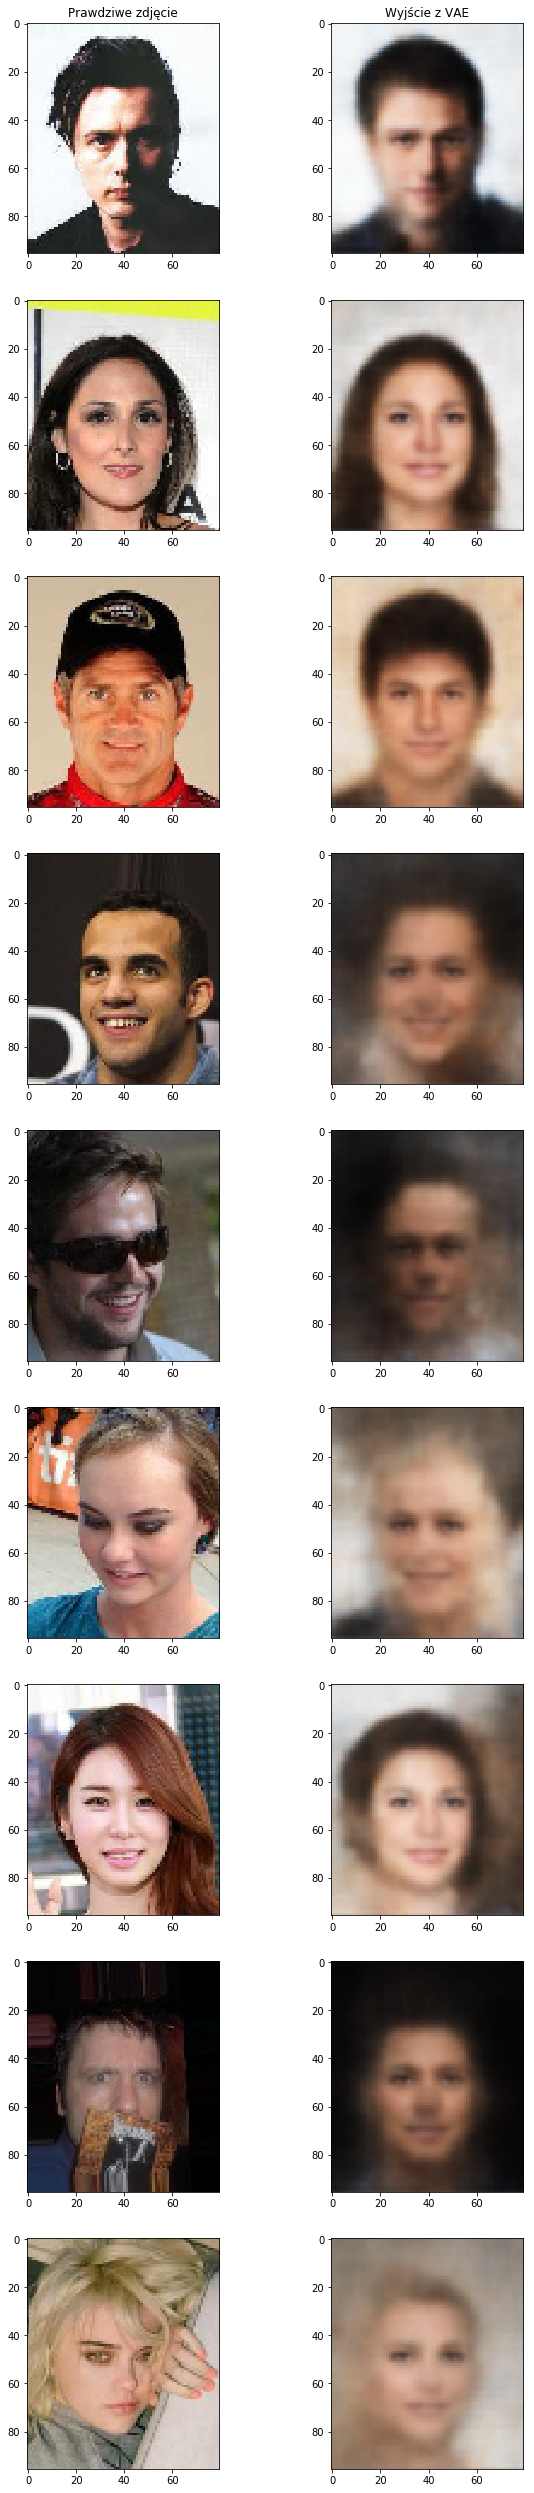

In [25]:
%matplotlib inline
plt.figure(figsize=(10,45))
for i in range(1,10):
    plt.subplot(9,2,i*2-1)
    if i==1:
        plt.title('Prawdziwe zdjęcie')
    plt.imshow(np.squeeze(X_train[i]))
    y_pred = vae.predict(np.expand_dims(X_train[i],0))
    plt.subplot(9,2,i*2)
    if i==1:
        plt.title('Wyjście z VAE')
    plt.imshow(np.squeeze(y_pred))

* dla zbioru testowego

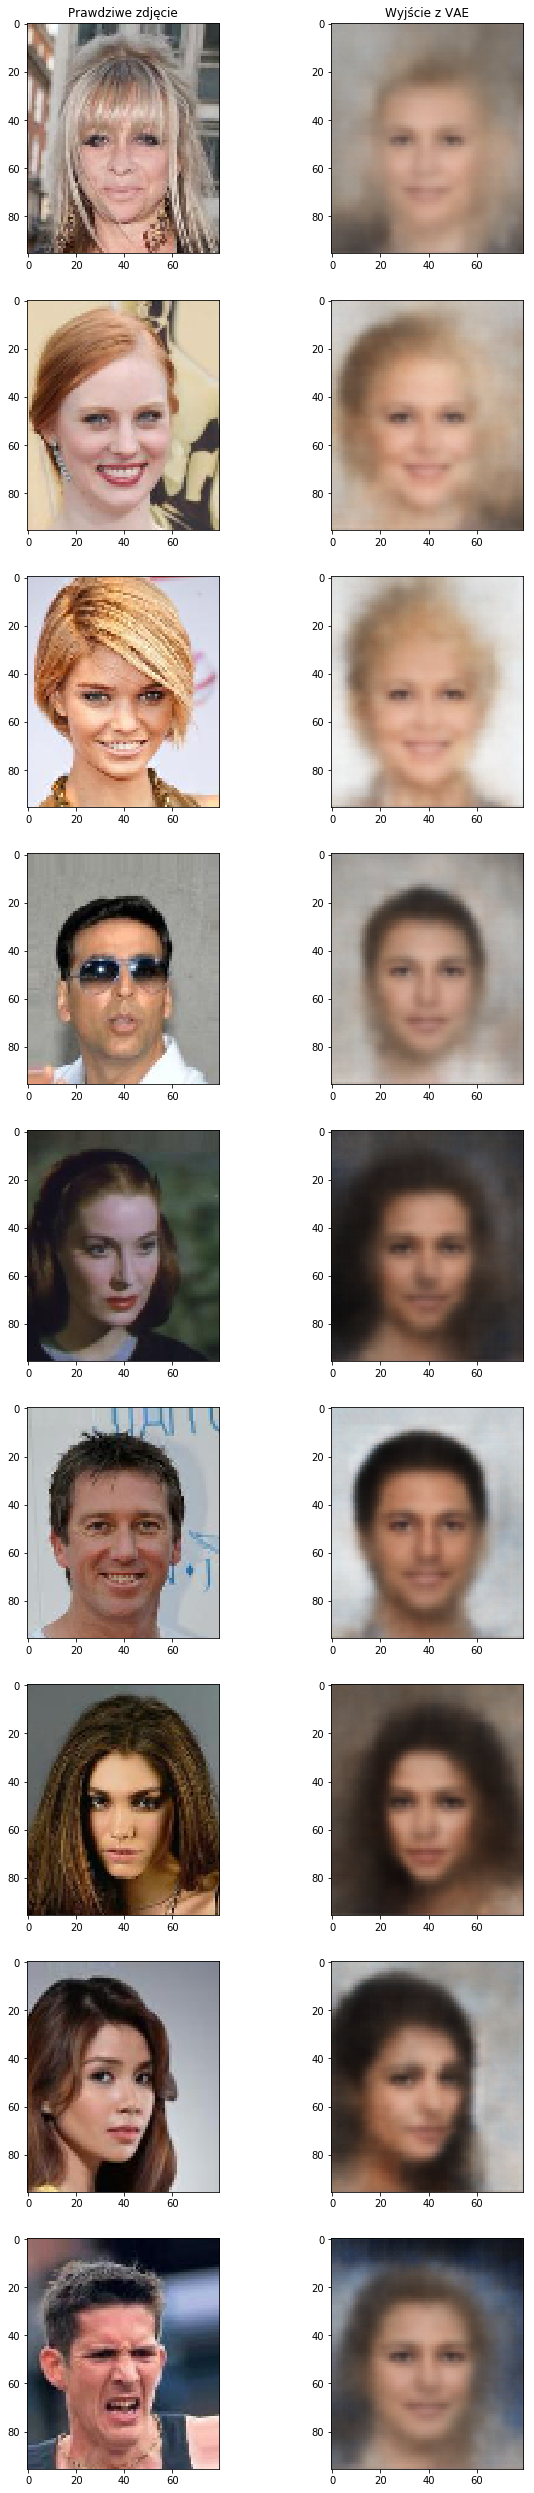

In [26]:
plt.figure(figsize=(10,45))
for i in range(1,10):
    plt.subplot(9,2,i*2-1)
    if i==1:
        plt.title('Prawdziwe zdjęcie')
    plt.imshow(np.squeeze(X_test[i]))
    y_pred = vae.predict(np.expand_dims(X_test[i],0))
    plt.subplot(9,2,i*2)
    if i==1:
        plt.title('Wyjście z VAE')
    plt.imshow(np.squeeze(y_pred))

## Jak wytrenowane cechy są wartościowe?

### Rozkłady gęstości prawdopodobieństwa dla poszczególnych cech

In [27]:
y_pred = encoder.predict(X_test)[2]

C:\Users\szymk\Miniconda3\envs\aipolsl_gpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


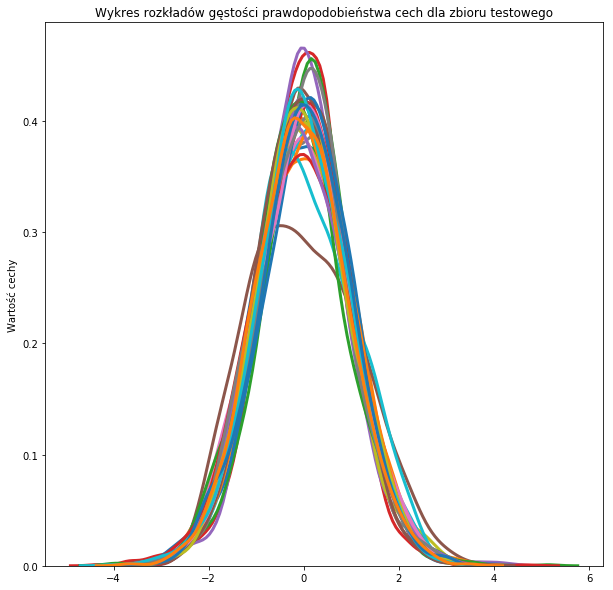

In [28]:
plt.figure(figsize=(10,10))
for i in range(latent_dim):
    sns.distplot(np.squeeze(y_pred[:,i]), hist = False, kde = True,kde_kws = {'linewidth': 3})
plt.title('Wykres rozkładów gęstości prawdopodobieństwa cech dla zbioru testowego')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.ylabel('Wartość cechy')
plt.show()

Jak można zauważyć rozkłady przypominają kształtem rozkład normalny.

### Jak prezentują się wyjścia z dekodera dla różnych wartości cech?

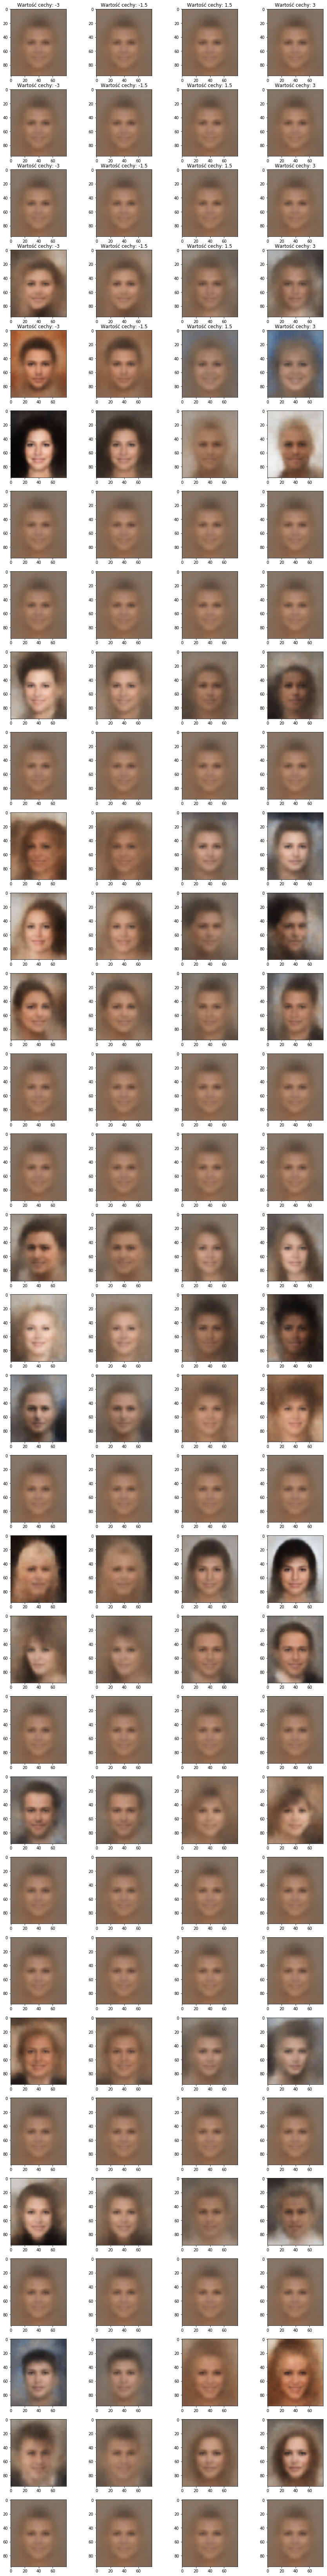

In [29]:
plt.figure(figsize=(15,120))
licznik = 1
for i in range(0,latent_dim):
    for wartosc in [-3,-1.5,1.5,3]:
        plt.subplot(32,4,licznik)
        if i<5:
            plt.title('Wartość cechy: '+str(np.round(wartosc,1)))
        X_enc = np.zeros((1,32))
        X_enc[0,i] = wartosc
        y_pred = decoder.predict(X_enc)
        plt.imshow(np.squeeze(y_pred))
        licznik+=1

### Poszukiwanie podobnych twarzy

TODO

Możemy podejrzewać, że niektóre cechy nie są do końca w pełni wystarczające do stworzenia wyjątkowych twarzy. Wartość informacji, które niosą niektóre z nich może być niewystarczająca. Jest to znany problem. Więcej tutaj: http://szhao.me/2017/06/10/a-tutorial-on-mmd-variational-autoencoders.html

### Stwórzmy losowe twarze

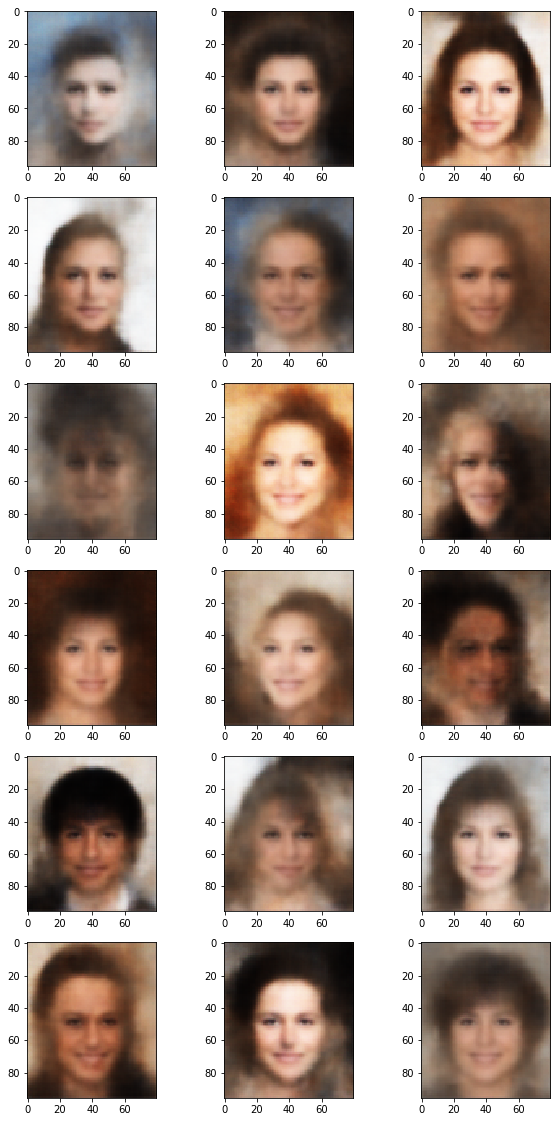

In [30]:
%matplotlib inline
plt.figure(figsize=(10,20))
for i in range(1,19):
    plt.subplot(6,3,i)
    y_pred = decoder.predict(np.random.randn(1,32))
    plt.imshow(np.squeeze(y_pred))

### Interaktywny interfejs do zmiany wartości cech i generacji twarzy

TODO